# TSSL Lab 3 - Nonlinear state space models and Sequential Monte Carlo
In this lab we will make use of a non-linear state space model for analyzing the dynamics of SARS-CoV-2, the virus causing covid-19. We will use an epidemiological model referred to as a Susceptible-Exposed-Infectious-Recovered (SEIR) model. It is a stochastic adaptation of the model used by the The Public Health Agency of Sweden for predicting the spread of covid-19 in the Stockholm region early in the pandemic, see [Estimates of the peak-day and the number of infected individuals during the covid-19 outbreak in the Stockholm region, Sweden February – April 2020](https://www.folkhalsomyndigheten.se/publicerat-material/publikationsarkiv/e/estimates-of-the-peak-day-and-the-number-of-infected-individuals-during-the-covid-19-outbreak-in-the-stockholm-region-sweden-february--april-2020/).

The background and details of the SEIR model that we will use are available in the document _TSSL Lab 3 Predicting Covid-19 Description of the SEIR model_ on LISAM. Please read through the model description before starting on the lab assignments to get a feeling for what type of model that we will work with.

<span style='color:Blue'>

__This lab assignment was complete by:__
    
- Juliana Gouveia de Sá Couto, julgo420
- Mohamed Ali, mohal954

---

### DISCLAIMER
Even though we will use a type of model that is common in epidemiological studies and analyze real covid-19 data, you should _NOT_ read to much into the results of the lab. The model is intentionally simplified to fit the scope of the lab, it is not validated, and it involves several model parameters that are set somewhat arbitrarily. The lab is intended to be an illustration of how we can work with nonlinear state space models and Sequential Monte Carlo methods to solve a problem of practical interest, but the actual predictions made by the final model should be taken with a big grain of salt.

---


We load a few packages that are useful for solving this lab assignment.

In [1]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)  # Increase default size of plots

## 3.1 A first glance at the data
The data that we will use in this lab is a time series consisting of daily covid-19-related intensive care cases in Stockholm from March 2020 to March 2021. As always, we start by loading and plotting the data.

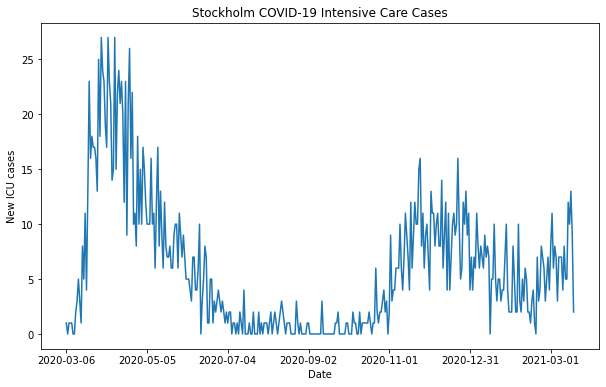

In [2]:
data=pandas.read_csv('SIR_Stockholm.csv',header=0)

y_sthlm = data['ICU'].values
u_sthlm = data['Date'].values

ndata = len(y_sthlm)

plt.plot(u_sthlm, y_sthlm)
plt.xticks(range(0, ndata, 60), u_sthlm[::60], rotation = 0)  # Show only one tick per 2 week for clarity

plt.xlabel('Date')
plt.ylabel('New ICU cases')
plt.title('Stockholm COVID-19 Intensive Care Cases')
plt.show()

**Q0:** What type of values can the observations $y_t$ take? Is a Gaussian likelihood model a good choice if we want to respect the properties of the data?

<span style='color:Blue'>
    
**A0:** The observations in this instance correspond to daily intensive care cases in Stockholm tied to COVID-19. Therefore,  values of yt would normally be non-negative integers because it is a count of cases.

A Gaussian (normal) likelihood model might not be the best option given the nature of count data. Contrasting with count data, which frequently has a discrete and non-negative nature, the Gaussian distribution implies continuous, symmetric, and unbounded data. A distribution like the Poisson distribution, which is frequently used for modeling count data, might be a better option for count data. It is made especially for events that happen at a known constant rate and are unaffected by the interval since the previous occurrence.

Accordingly, models utilizing a likelihood function based on the Poisson distribution or its extensions, such as the negative binomial distribution, which can account for overdispersion in count data should be used in this context, in order to respect the attributes of the count data (non-negative integers).
    
__Conclusion:__ In this scenario, a linear state-based model, which assumes Gaussianity, may not be the most suitable choice. An alternative approach would be to employ a non-linear state-based model.

## 3.2 Setting up and simulating the SEIR model
In this section we will set up a SEIR model and use this to simulate a synthetic data set. You should keep these simulated trajectories, we will use them in the following sections.

In [3]:
from tssltools_lab3 import Param, SEIR

"""For Stockholm the population is probably roughly 2.5 million."""
population_size = 2500000  

"""" Binomial probabilities (p_se, p_ei, p_ir, and p_ic) and the transmission rate (rho)"""
pse = 0        # This controls the rate of spontaneous s->e transitions. It is set to zero for this lab.
pei = 1 / 5.1  # Based on FHM report
pir = 1 / 5    # Based on FHM report
pic = 1 / 1000 # Quite arbitrary!
rho = 0.3      # Quite arbitrary!

""" The instantaneous contact rate b[t] is modeled as
  b[t] = exp(z[t])
  z[t] = z[t-1] + epsilon[t], epsilon[t] ~ N(0,sigma_epsilon^2)
"""
sigma_epsilon = .1

""" For setting the initial state of the simulation"""
i0 = 1000  # Mean number of infectious individuals at initial time point
e0 = 5000  # Mean number of exposed...
r0 = 0     # Mean number of recovered
s0 = population_size - i0 - e0 - r0  # Mean number of susceptible
init_mean = np.array([s0, e0, i0, 0.], dtype = np.float64)  # The last 0. is the mean of z[0]

"""All the above parameters are stored in params."""
params = Param(pse, pei, pir, pic, rho, sigma_epsilon, init_mean, population_size)

""" Create a model instance"""
model = SEIR(params)

**Q1:** Generate $10$ different trajectories of length $200$ from the model an plot them in one figure. Does the trajectories look reasonable? Could the data have been generated using this model? 

For reproducability, we set the seed of the random number generator to 0 before simulating the trajectories using np.random.seed(0)

Save these $10$ generated trajectories for future use.

*(hint: The SEIR class has a simulate method)*

In [4]:
np.random.seed(0)

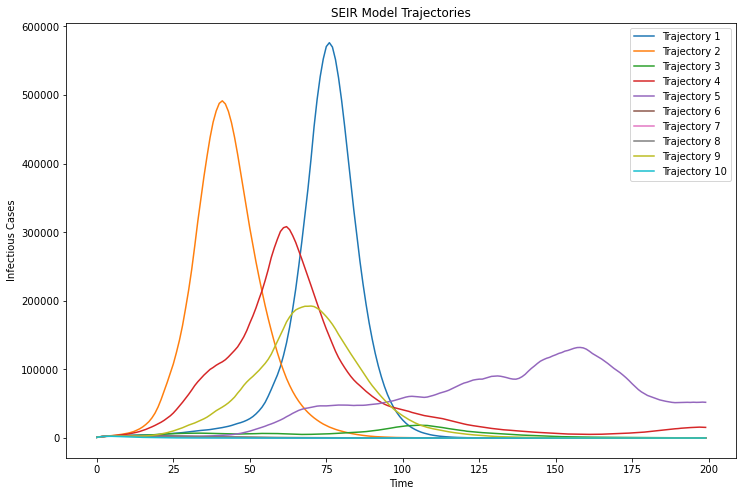

In [5]:
trajectory_num = 10
trajectory_length = 200

alpha_trajectories, y_observations = model.simulate(trajectory_length, trajectory_num)

plt.figure(figsize=(12, 8))
for i in range(trajectory_num):
    plt.plot(alpha_trajectories[2, i,], label = f'Trajectory {i + 1}')

plt.title('SEIR Model Trajectories')
plt.xlabel('Time')
plt.ylabel('Infectious Cases')
plt.legend()
plt.show()

<span style='color:Blue'>
    
**A1:** There are no recurring patterns in the graphs of the real data and all the simulated observations. The SEIR model may not be a suitable representation for the actual data as there are discrepancies in the epidemic curve's form, variations in the timing of crucial events, or variations in the peak's magnitude. 
    
__Conclusion:__ Even though some simulations exhibit a pattern that substantially resembles the actual COVID-19 data, we cannot definitively claim that this model was used to create the data.

## 3.3 Sequential Importance Sampling

Next, we pick out one trajectory that we will use for filtering. We use simulated data to start with, since we then know the true underlying SEIR states and can compare the filter results with the ground truth.

**Q2:** Implement the **Sequential Importance Sampling** algorithm by filling in the following functions.

The **exp_norm** function should return the normalized weights and the log average of the unnormalized weights.
For numerical reasons, when calculating the weights we should "normalize" the log-weights first by removing the maximal value.

Let $\bar{\omega}_t = \max(\log \omega_t^i)$ and take the exponential of $\log \tilde{\omega}_t^i = \log \omega_t^i - \bar{\omega}_t$. Normalizing $\tilde{\omega}_t^i$ will yield the normalized weights!

For the log average of the unnormalized weights, care has to be taken to get the correct output,
$\log (1/N \sum_{i=1}^{N} \tilde{\omega}_t^i) = \log( 1/N \sum_{i=1}^{N} \omega_t^i) - \bar{\omega}_t$.
We are going to need this in the future, so best to implement it right away.

*(hint: look at the SEIR model class, it contains all necessary functions for propagation and weighting)*

In [6]:
from tssltools_lab3 import smc_res

In [7]:
def exp_norm(logwgt):
    """
    Exponentiates and normalizes the log-weights.
    
    Parameters
    ----------
    logwgt : ndarray
        Array of size (N,) with log-weights.
    
    Returns
    -------
    wgt : ndarray
        Array of size (N,) with normalized weights, wgt[i] = exp(logwgt[i])/sum(exp(logwgt)),
        but computed in a /numerically robust way/!
    logZ : float
        log of the normalizing constant, logZ = log(sum(exp(logwgt))),
        but computed in a /numerically robust way/!
    """     
    
    logwgt_max = np.max(logwgt)  # Find the maximum log-weight
    logwgt_tilde = logwgt - logwgt_max  # Normalize the log-weights

    wgt = np.exp(logwgt_tilde)  # Exponentiate
    wgt /= np.sum(wgt)  # Normalize

    logZ = np.log(np.sum(np.exp(logwgt))) + logwgt_max  # Compute log normalizing constant
    
    return wgt, logZ

In [8]:
def ESS(wgt):
    """
    Computes the effective sample size.
    
    Parameters
    ----------
    wgt : ndarray
        Array of size (N,) with normalized importance weights.
    
    Returns
    -------
    ess : float
        Effective sample size.
    """         
    ess = (np.sum(wgt) ** 2) / np.sum(wgt ** 2)
    
    return ess

In [9]:
def sis_filter(model, y, N):
    d = model.d
    n = len(y)
    
    # Allocate memory
    particles = np.zeros((d, N, n), dtype = float)  # All generated particles
    logW = np.zeros((1, N, n))  # Unnormalized log-weight
    W = np.zeros((1, N, n))  # Normalized weight
    alpha_filt = np.zeros((d, 1, n))  # Store filter mean
    N_eff = np.zeros(n)  # Efficient number of particles
    logZ = 0.  # Log-likelihood estimate

    # Filter loop
    for t in range(n):
        # Sample from "bootstrap proposal"
        if t == 0:
            particles[:, :, t] = model.sample_state(alpha0 = None, N = N) # Initialize from p(alpha_1)
            logW[0, :, t] = model.log_lik(y = y[t], alpha = particles[:, :, t]) # Compute weights
        else:
            particles[:, :, t] = model.sample_state(alpha0 = particles[:, :, t-1], N = N) # Propagate according to dynamics
            logW[0, :, t] = model.log_lik(y = y[t], alpha = particles[:, :, t]) + logW[0, :, t-1]  # Update weights

        # Normalize the importance weights and compute N_eff
        W[0, :, t], _ = exp_norm(logW[0, :, t])
        N_eff[t] = ESS(W[0,:,t])
        
        # Compute filter estimates
        alpha_filt[:, 0, t] = np.sum(W[0, :, t] * particles[:, :, t], axis = 1) 
        
    return smc_res(alpha_filt, particles, W, logW = logW, N_eff = N_eff)

**Q3:** Choose one of the simulated trajectories and run the SIS algorithm using $N = 100$ particles. Show plots comparing the filter means from the SIS algorithm with the underlying truth of the Infected, Exposed and Recovered. 

Also show a plot of how the ESS behaves over the run. 

*(hint: In the model we use the S, E, I as states, but S will be much larger than the others. To calculate R, note that S + E + I + R = Population)*

In [10]:
# Number of particles
N = 100

# Choose one simulated trajectory
true_alpha = alpha_trajectories[0, 0, :]
true_y = y_observations[0, 0, :]

# Run Sequential Importance Sampling and store filter means 
filter_result = sis_filter(model, true_y, N)

<ipython-input-7-60471a1ae68b>:26: RuntimeWarning: divide by zero encountered in log
  logZ = np.log(np.sum(np.exp(logwgt))) + logwgt_max  # Compute log normalizing constant


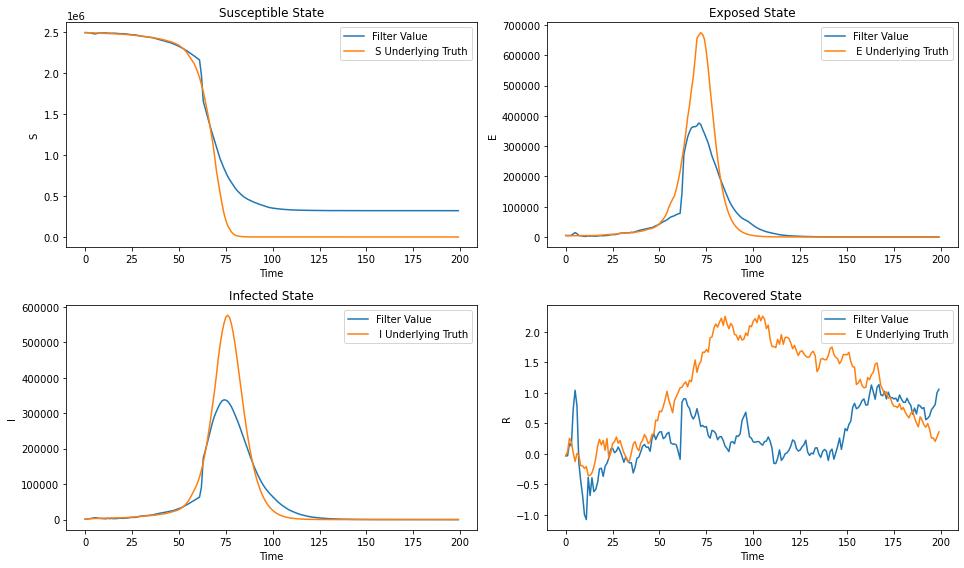

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(13.5, 8))

axes[0, 0].plot(filter_result.alpha_filt[0, 0, :], label = 'Filter Value')
axes[0, 0].plot(alpha_trajectories[0, 0, :], label = ' S Underlying Truth')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('S')
axes[0, 0].set_title('Susceptible State')
axes[0, 0].legend()

axes[0, 1].plot(filter_result.alpha_filt[1, 0, :], label = 'Filter Value')
axes[0, 1].plot(alpha_trajectories[1, 0, :], label = ' E Underlying Truth')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('E')
axes[0, 1].set_title('Exposed State')
axes[0, 1].legend()

axes[1, 0].plot(filter_result.alpha_filt[2, 0, :], label = 'Filter Value')
axes[1, 0].plot(alpha_trajectories[2, 0, :], label = ' I Underlying Truth')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('I')
axes[1, 0].set_title('Infected State')
axes[1, 0].legend()

axes[1, 1].plot(filter_result.alpha_filt[3, 0, :], label = 'Filter Value')
axes[1, 1].plot(alpha_trajectories[3, 0, :], label = ' E Underlying Truth')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('R')
axes[1, 1].set_title('Recovered State')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

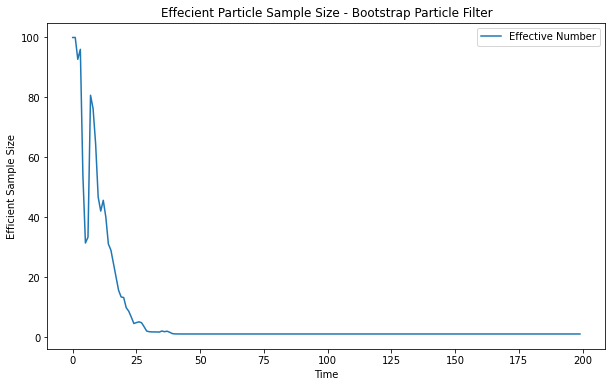

In [12]:
plt.plot(filter_result.N_eff, label = 'Effective Number')

plt.xlabel('Time')
plt.ylabel('Efficient Sample Size')
plt.title('Effecient Particle Sample Size - Bootstrap Particle Filter')

plt.legend()
plt.show()

## 3.4 Sequential Importance Sampling with Resampling

Pick the same simulated trajectory as for the previous section.

**Q4:** Implement the **Sequential Importance Sampling with Resampling** or **Bootstrap Particle Filter** by completing the code below.

In [13]:
def bpf(model, y, numParticles):
    d = model.d
    n = len(y)
    N = numParticles
    
    # Allocate memory
    particles = np.zeros((d, N, n), dtype = float)  # All generated particles
    logW = np.zeros((1, N, n))  # Unnormalized log-weight
    W = np.zeros((1, N, n))  # Normalized weight
    alpha_filt = np.zeros((d, 1, n))  # Store filter mean
    N_eff = np.zeros(n)  # Efficient number of particles
    logZ = 0.  # Log-likelihood estimate

    # Filter loop
    for t in range(n):
        # Sample from "bootstrap proposal"
        if t == 0:  # Initialize from prior
            particles[:, :, 0] = model.sample_state(N = N)
        else:  # Resample and propagate according to dynamics
            ind = np.random.choice(N, N, replace = True, p = W[0, :, t-1])
            resampled_particles = particles[:, ind, t-1] 
            particles[:, :, t] = model.sample_state(alpha0 = resampled_particles, N = N) 

        # Compute weights
        logW[0, :, t] = model.log_lik(y[t], alpha = particles[:, :, t]) 
        W[0, :, t], logZ_now = exp_norm(logW[0, :, t])
        logZ += logZ_now # Update log-likelihood estimate
        N_eff[t] = ESS(W[0, :, t])

        # Compute filter estimates
        alpha_filt[:, 0, t] = np.sum(W[0, :, t] * particles[:, :, t], axis = 1) 
        
    return smc_res(alpha_filt, particles, W, N_eff = N_eff, logZ = logZ)

**Q5:** Use the same simulated trajectory as above and run the BPF algorithm using $N = 100$ particles. Show plots comparing the filter means from the Bootstrap Particle Filter algorithm with the underlying truth of the Infected, Exposed and Recovered. Also show a plot of how the ESS behaves over the run. Compare this with the results from the SIS algorithm.

In [14]:
# Number of particles
N = 100

# Choose one simulated trajectory
bpf_true_alpha = alpha_trajectories[0, 0, :]
bpf_true_y = y_observations[0, 0, :]

# Run Sequential Importance Sampling and store filter means 
bpf_filter_result = bpf(model, bpf_true_y, N)

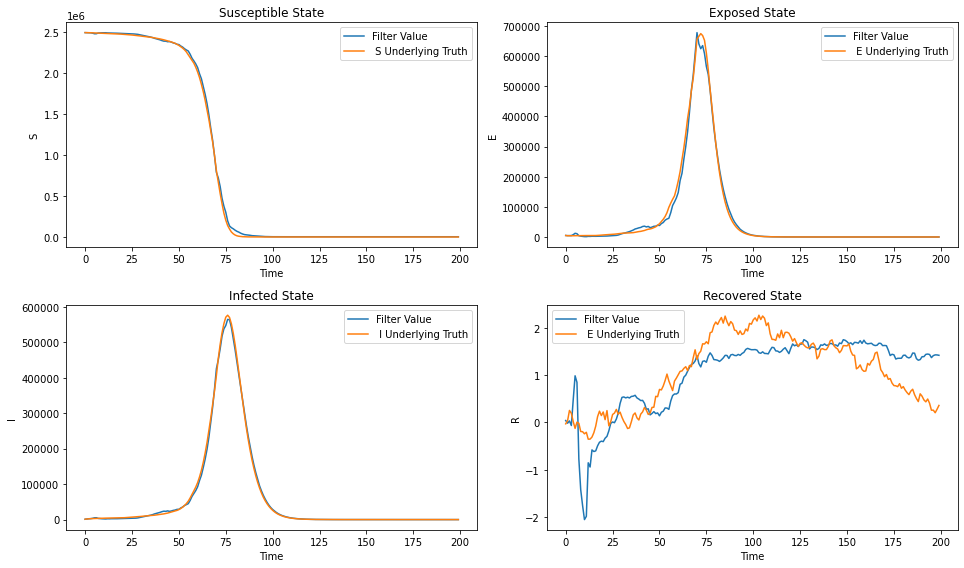

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(13.5, 8))

axes[0, 0].plot(bpf_filter_result.alpha_filt[0, 0, :], label = 'Filter Value')
axes[0, 0].plot(alpha_trajectories[0, 0, :], label = ' S Underlying Truth')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('S')
axes[0, 0].set_title('Susceptible State')
axes[0, 0].legend()

axes[0, 1].plot(bpf_filter_result.alpha_filt[1, 0, :], label = 'Filter Value')
axes[0, 1].plot(alpha_trajectories[1, 0, :], label = ' E Underlying Truth')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('E')
axes[0, 1].set_title('Exposed State')
axes[0, 1].legend()

axes[1, 0].plot(bpf_filter_result.alpha_filt[2, 0, :], label = 'Filter Value')
axes[1, 0].plot(alpha_trajectories[2, 0, :], label = ' I Underlying Truth')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('I')
axes[1, 0].set_title('Infected State')
axes[1, 0].legend()

axes[1, 1].plot(bpf_filter_result.alpha_filt[3, 0, :], label = 'Filter Value')
axes[1, 1].plot(alpha_trajectories[3, 0, :], label = ' E Underlying Truth')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('R')
axes[1, 1].set_title('Recovered State')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

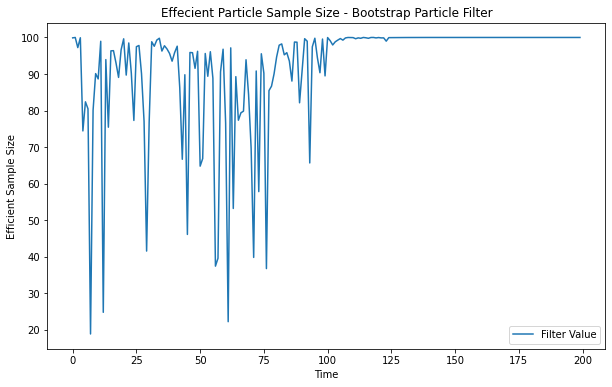

In [16]:
plt.plot(bpf_filter_result.N_eff, label = 'Filter Value')

plt.xlabel('Time')
plt.ylabel('Efficient Sample Size')
plt.title('Effecient Particle Sample Size - Bootstrap Particle Filter')

plt.legend()
plt.show()

## 3.5 Estimating the data likelihood and learning a model parameter
In this section we consider the real data and learning the model using this data. For simplicity we will only look at the problem of estimating the $\rho$ parameter and assume that others are fixed.

You are more than welcome to also study the other parameters.

Before we begin to tweak the parameters we run  the particle filter using the current parameter values to get a benchmark on the log-likelihood.

**Q6:** Run the bootstrap particle filter using $N=200$ particles on the real dataset and calculate the log-likelihood. Rerun the algorithm 20 times and show a box-plot of the log-likelihood.

Log-likelihood Mean: 322.0586126347456


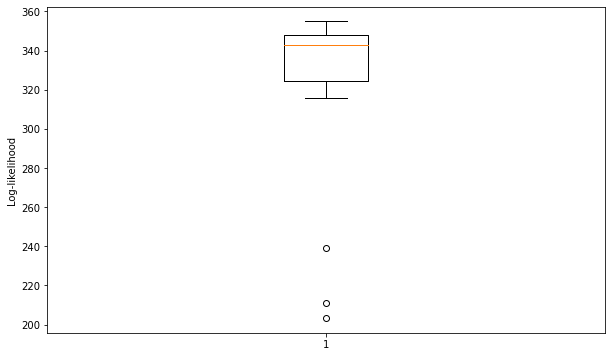

In [17]:
# Number of particles
N = 200

n = 20
log_likelihood = np.zeros(n)

for i in range(n):
    bpf_filter_result = bpf(model, true_y, N)
    log_likelihood[i] = bpf_filter_result.logZ

print('Log-likelihood Mean: ' + str(np.mean(log_likelihood)))

plt.boxplot(log_likelihood)
plt.ylabel('Log-likelihood')
plt.show()

**Q7:** Make a grid of the $\rho$ parameter in the interval $[0.1, 0.9]$. Use the bootstrap particle filter to calculate the log-likelihood for each value. Run the bootstrap particle filter using $N=200$ multiple times (at least 20) per value and use the average as your estimate of the log-likelihood. Plot the log-likelihood function and mark the maximal value.

*(hint: use np.linspace to create a grid of parameter values)*

In [18]:
step = 100
iterations = 20

grid_list = np.linspace(0.1, 0.9, step)
logZ_result = np.zeros((len(grid_list), iterations))

for i in range(len(grid_list)):
    model.set_param(grid_list[i])
    
    for j in range(iterations):
        bpf_logZ_result = bpf(model, y_sthlm, N)
        logZ_result[i,j]= bpf_logZ_result.logZ
        
logZ_mean = np.mean(logZ_result, axis = 1)

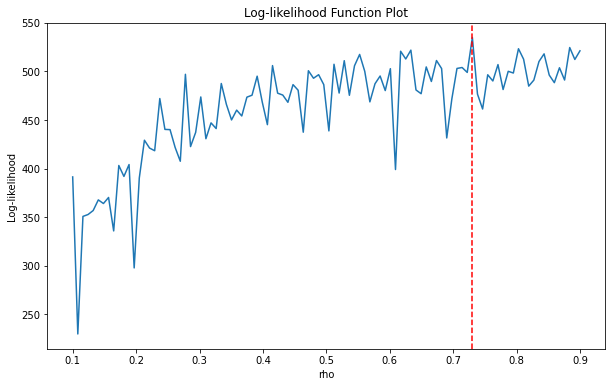

In [19]:
plt.plot(grid_list, logZ_mean)
plt.axvline(grid_list[np.argmax(logZ_mean)], linestyle = '--', color = 'red')

plt.xlabel('rho')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood Function Plot')
plt.show()

**Q8:** Run the bootstrap particle filter on the full dataset with the optimal $\rho$ value. Present a plot of the estimated Infected, Exposed and Recovered states.

In [22]:
optimal_rho = grid_list[np.argmax(logZ_mean)]

parameters = Param(pse, pei, pir, pic, optimal_rho, sigma_epsilon, init_mean, population_size)
model = SEIR(parameters)
optimal_result = bpf(model, y_sthlm, numParticles = N)

recovered_number = population_size - sum(optimal_result.alpha_filt[:3, 0, :])

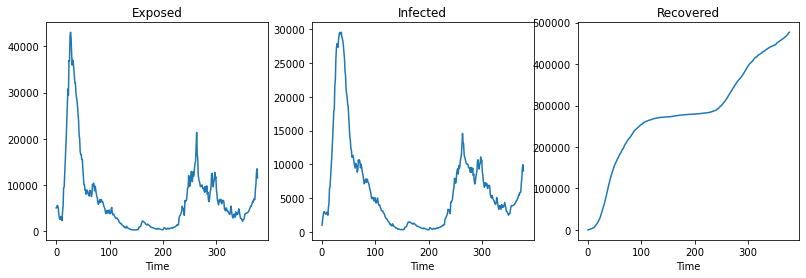

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(13.5, 4))

axes[0].plot(optimal_result.alpha_filt[1, 0, :], label = 'Exposed')
axes[0].set_xlabel('Time')
axes[0].set_title('Exposed')

axes[1].plot(optimal_result.alpha_filt[2, 0, :], label = 'Infected')
axes[1].set_xlabel('Time')
axes[1].set_title('Infected')

axes[2].plot(recovered_number, label = 'Recovered')
axes[2].set_xlabel('Time')
axes[2].set_title('Recovered')

plt.show()